# TBrain Esunbank Suspicious Activity Report


## Import Package


In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [3]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Sun Dec 25 22:37:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P2    28W / 160W |   1202MiB /  6144MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Helper Functions


Before we write the code for adjusting the models, lets define a few helper functions.


In [5]:
from utils.metrics import recall_n, rmse 

In [6]:
def cdtx_from_date_to_byymm(date, byymm_list):
    byymm = None # [0, 30, 61, 91, 122, 153, 183, 214, 244, 275, 306, 334, 365]
    for i in range(len(byymm_list)):
        # If it is already the last bymm, and the current date is greater than bymm, it belongs to the last cycle
        if(byymm_list[i] == byymm_list[len(byymm_list)-1]):
            if(byymm_list[i] <= date):
                byymm = byymm_list[i]
        else:
            # If the current date is greater than bymm and less than the next bymm, it belongs to the current period
            if(byymm_list[i] <= date < byymm_list[i+1]):
                byymm = byymm_list[i]
    return byymm

In [7]:
# Processing of data provided by the organizer 
def alert_data_merge(alert, answer, custinfo):
    data = pd.merge(answer, alert, on=['alert_key'], how='left')
    data = pd.merge(data, custinfo, on='alert_key', how='left')
    return data

In [8]:
def apply_exclusion_rules(np2d, features, feature = 'occupation_code_2.0', value = 1):
    # find index of feature in features
    index_of_feature = features.index(feature)
    # if any feature is value, then set probability to 0
    return np.any(np2d[:, index_of_feature] == value)

## Const & Inputs


Here are all of the parameters to change for the run.


In [204]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# look_back
look_back = 30

# Numerical
numerical = [
    # 'day_of_year',
    # 'lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah',
    'risk_rank', 
    'total_asset', 
    'AGE', 
    # 'trade_amount_usd', 
    'trade_amount_usd_ratio', 
    'trans_counts', 
    # 'cdtx_amt', 
    'cdtx_amt_ratio', 
    'cdtx_counts',
    # 'dp_amt_debit', 'dp_amt_credit', 
    'dp_amt_debit_ratio', 'dp_amt_credit_ratio', 
    'dp_counts_debit', 'dp_counts_credit',
]

# Binary
binary = ['cdtx_country_is_tw', 'cdtx_cur_type_is_twd']

# Categorical
categorical = [
    'occupation_code', #22 
    'trans_no', #6
    # 'cdtx_country', 'cdtx_cur_type', #123, 49
    'tx_type_debit', 'tx_type_credit', #4, 4
    # 'info_asset_code_debit', 'info_asset_code_credit', #21, 21
    'cross_bank_debit', 'cross_bank_credit', #3, 3
    'ATM_debit', 'ATM_credit', #3, 3
    'has_txbranch_debit', 'has_txbranch_credit', #3, 3
    'day_of_week',
]

# 2020 為閏年 2 月有 29 天，這裡 2 月只有 28 天所以是 2021 年
byymm_mapping = {
    '0': '2020/03', '30': '2020/04', '61': '2020/05', '91': '2020/06', '122': '2020/07', 
    '153': '2020/08', '183': '2020/09', '214': '2020/10', '244': '2020/11', '275': '2020/12',
    '306': '2021/01', '334': '2021/02', '365': '2021/03'
}

## Load X and Y


### custinfo


In [10]:
custinfo_public = pd.read_csv(os.path.join(path, 'data/public_train_x_custinfo_full_hashed.csv'))
custinfo_private = pd.read_csv(os.path.join(path, 'data/private_x_custinfo_full_hashed.csv'))
custinfo = pd.concat([custinfo_public, custinfo_private], axis=0)
print('custinfo.cust_id.size:', len(custinfo.groupby('cust_id').size()))
custinfo.head(3)

custinfo.cust_id.size: 8151


,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7


Handle Missing Values


In [11]:
custinfo['occupation_code'] = custinfo['occupation_code'].fillna(21)

### alert and flag

Combine x and y


In [12]:
train_alert = pd.read_csv(os.path.join(path, 'data/train_x_alert_date.csv'))
train_y_answer = pd.read_csv(os.path.join(path, 'data/train_y_answer.csv'))
public_alert = pd.read_csv(os.path.join(path, 'data/public_x_alert_date.csv'))
public_y_answer = pd.read_csv(os.path.join(path, 'data/public_y_answer.csv'))
private_alert = pd.read_csv(os.path.join(path, 'data/private_x_alert_date.csv'))
private_y_answer = pd.DataFrame({'alert_key': private_alert['alert_key'], 'sar_flag': [np.nan]*len(private_alert)})

In [13]:
# TODO: concat with private alert
full_alert  = pd.concat([train_alert, public_alert, private_alert], axis=0, ignore_index=True)
full_y_answer = pd.concat([train_y_answer, public_y_answer, private_y_answer], axis=0, ignore_index=True)

In [14]:
full_df = alert_data_merge(full_y_answer, full_alert, custinfo)
full_df = full_df.dropna(subset=['sar_flag'])
full_df.head(5)

,alert_key,date,set_name,day_of_year,month_of_year,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171189,0,train,0.0,4.0,0.0,972ee157e63316e8a50dd489bc93730a3ee8a8959d5c6b...,1,17.0,375576.0,4
1,171202,0,train,0.0,4.0,0.0,a10ab33f90926fb18d7bb5e78034d7f04a1fbed95b7951...,3,12.0,2717416.0,2
2,171599,0,train,0.0,4.0,0.0,3433ecc068ed1c9e2f5037cab5d42d7b901e9bd624c1fb...,1,12.0,326517.0,4
3,171737,0,train,0.0,4.0,0.0,a0861608615a9365d90f4ba0a813c0ea0471987f925c8b...,3,14.0,1014759.0,4
4,171142,0,train,0.0,4.0,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3


In [15]:
private_df = alert_data_merge(private_y_answer, private_alert, custinfo)
private_df.head(3)

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,370282,397,NaN,59137878114c4210c5f28a49b0e6ae754c0e42387a4302...,3,12.0,419256.0,3
1,369792,397,NaN,cd1bfab2b5aede00574f4308821d4ea38f32460f3cf489...,1,12.0,0.0,4
2,370155,397,NaN,e50deb3f2f87bf45e04940303f80c96929c836b0b03f54...,1,12.0,304592.0,4


## Convert to Daily Data


Processing of data provided by the organizer.


### custinfo with date

原始的 custinfo 沒有時間戳記，難以與其他資料整合，這邊與 alert 資料合併取得時間戳記


In [37]:
custinfo_with_date = custinfo.copy()
custinfo_with_date = pd.merge(custinfo_with_date, full_alert, on='alert_key', how='left').drop(['set_name'], axis=1)
custinfo_with_date.describe()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date,day_of_year,month_of_year
count,27756.000000,27756.000000,27756.000000,2.775600e+04,27756.000000,27756.000000,25751.000000,25751.000000
mean,273319.024355,1.601888,14.233067,7.041168e+05,3.623361,213.417423,172.012621,9.257349
std,62752.873984,0.902145,4.731681,2.365246e+06,1.310938,126.369561,115.431300,3.835843
min,171142.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,4.000000
25%,216475.750000,1.000000,12.000000,7.894000e+03,3.000000,102.000000,56.000000,5.000000
50%,275795.000000,1.000000,15.000000,1.315045e+05,3.000000,229.000000,179.000000,9.000000
75%,327268.500000,3.000000,19.000000,6.011390e+05,4.000000,320.000000,273.000000,13.000000
max,378428.000000,3.000000,21.000000,7.386321e+07,10.000000,425.000000,364.000000,16.000000


可以發現每隔 5 日會有 2 日被跳過，推測銀行假日不作業，而跳過的 2 日為假日

從下列資料來看，最開始的週期為 4, 5, 6, 7, 8, 9, 10


In [40]:
custinfo_with_date['date'].sort_values().unique()

array([  0,   5,   6,   7,   8,  11,  12,  13,  14,  15,  18,  19,  20,
        21,  22,  25,  26,  27,  28,  32,  33,  34,  35,  36,  39,  40,
        41,  42,  43,  46,  47,  48,  49,  50,  53,  54,  55,  56,  57,
        60,  61,  62,  63,  64,  67,  68,  69,  70,  71,  75,  76,  77,
        78,  81,  82,  83,  84,  85,  88,  89,  90,  91,  92,  95,  96,
        97,  98,  99, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113,
       116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 130, 131, 132,
       133, 134, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 151,
       152, 153, 154, 155, 158, 159, 160, 161, 162, 163, 165, 166, 167,
       168, 169, 174, 175, 176, 179, 180, 181, 182, 183, 186, 187, 188,
       189, 190, 194, 195, 196, 197, 200, 201, 202, 203, 204, 207, 208,
       209, 210, 211, 215, 216, 217, 218, 221, 222, 223, 224, 225, 229,
       230, 231, 232, 235, 236, 237, 238, 239, 242, 244, 245, 246, 250,
       251, 252, 253, 257, 258, 259, 260, 263, 265, 266, 267, 27

In [41]:
date1 = np.array([4, 5, 6, 7, 8, 9, 10]) # 0, 1, 2, 3, 4, 5, 6
date2 = np.array([11, 12, 13, 14, 15, 16, 17]) # 0, 1, 2, 3, 4, 5, 6
date3 = np.array([18, 19, 20, 21, 22, 23, 24]) # 0, 1, 2, 3, 4, 5, 6
print((date1 - 4)%7+1)
print((date2 - 4)%7+1)
print((date3 - 4)%7+1)

[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]


### convert to daily data

時間序列模型可以基於警報發生當下及過去的資料來判斷警報嚴重程度，其中對於過去資料的回推單位在這裡設定為 1 日，為此必須先克服 2 個問題

1. 資料在 1 日內可能有複數筆，例如：警報在同 1 日可能發生複數次、匯款或信用卡交易在同 1 日可能發生複數次

2. 資料的前後間隔可能超過 1 日，例如：客戶在 2020.11.17 匯款後，下次匯款可能在 2 日後的 2020.11.19 發生


#### alert

警報是最關鍵的屬性，因為它代表 y 的頻率，若警報在單 1 日內觸發多次的頻率過高，就不能將回推單位設定為 1 天

同 1 個客戶在單日觸發 2 次警報的情況在 training set 為 1.1495% 應該可以先忽略不理會


In [42]:
single_day_multi_alerts = full_df.groupby(['cust_id', 'date']).size().reset_index(name='counts')
single_day_multi_alerts = single_day_multi_alerts[single_day_multi_alerts['counts']>1]
print('train:', len(full_df))
print('single_day_multi_alerts:', len(single_day_multi_alerts))
print(F'{len(single_day_multi_alerts)} / {len(full_df)} = {round(len(single_day_multi_alerts)/len(full_df)*100, 4)}%')

train: 25751
single_day_multi_alerts: 296
296 / 25751 = 1.1495%


#### custinfo

檢查客戶在 1 日內的 custinfo 資訊是否相同，若相同的話就能夠以 1 日為單位平均起來，若有變化就要想辦法處理


將 custinfo 依 cust_id, date 及任意 1 個欄位分組，並計算每個群組的資料筆數，該數量表示同 1 個顧客在 1 日內的複數警報數

1. 可以發現以 occupation_code 為條件群組的時候，重複資料的筆數由 296 筆降低為 293 筆，顯示有 3 筆資料的 occupation_code 在 1 日內發生變化

2. 可以發現以 total_asset 為條件群組的時候，重複資料的筆數由 296 筆降低為 151 筆，顯示有 145 筆資料的 total_asset 在 1 日內發生變化


In [43]:
for column in ['risk_rank', 'occupation_code', 'AGE', 'total_asset']:
    alerts_groupby_cust_date = custinfo_with_date.groupby(['cust_id', 'date', column]).size().reset_index(name='counts')
    single_day_multi_alerts = alerts_groupby_cust_date[alerts_groupby_cust_date['counts']>1]
    print(F'single_day_multi_alerts ({column}):', len(single_day_multi_alerts))

single_day_multi_alerts (risk_rank): 296
single_day_multi_alerts (occupation_code): 293
single_day_multi_alerts (AGE): 296
single_day_multi_alerts (total_asset): 151


對於 occupation_code 及 total_asset 可能在 1 日內變化的問題，暫時決定先以當日最後 1 筆資料的值做代表

屬性 alert_key 應該是有順序性的，故使用 alert_key 排序後 drop_duplicates and keep last


In [44]:
custinfo_with_date_drop_duplicates_by_date = custinfo_with_date.copy().sort_values(by=['alert_key'], ignore_index=True)
custinfo_with_date_drop_duplicates_by_date = custinfo_with_date_drop_duplicates_by_date.drop_duplicates(subset=['cust_id', 'date'], keep='last', ignore_index=True).drop(['alert_key'], axis=1)
print('custinfo_with_date_drop_duplicates_by_date:', len(custinfo_with_date_drop_duplicates_by_date))

custinfo_with_date_drop_duplicates_by_date: 27460


#### remit

每天可能有多筆外匯紀錄，但這裡先把他們都加總起來，以 date 為最小單位


In [45]:
remit_public = pd.read_csv(os.path.join(path, 'data/public_train_x_remit1_full_hashed.csv')).rename(columns={'trans_date': 'date'})
remit_private = pd.read_csv(os.path.join(path, 'data/private_x_remit1_full_hashed.csv')).rename(columns={'trans_date': 'date'})
remit = pd.concat([remit_public, remit_private], axis=0, ignore_index=True) 
print('remit.date.minmax:', remit['date'].min(), remit['date'].max())
print('remit.cust_id.size:', len(remit.groupby('cust_id').size()))

remit.date.minmax: 0 425
remit.cust_id.size: 1213


屬性 trans_no 是類別值，沒辦法直接加總或平均，這裡以 1 日內金額最高的那次為代表，另外也計算 1 日內交易次數 trans_counts


先根據 trade_amount_usd 由小到大排序，這樣 trans_no 取 last 就會得到當日最高交易金額的交易類型


In [47]:
remit_groupby_date = remit.copy().sort_values(by=['cust_id', 'date', 'trade_amount_usd'])
remit_groupby_date = remit_groupby_date.groupby(['cust_id', 'date']).agg(trade_amount_usd=('trade_amount_usd', 'sum'), trans_no=('trans_no', 'last'), trans_counts=('trans_no', 'count')).reset_index()
remit_groupby_date.head(5)

,cust_id,date,trade_amount_usd,trans_no,trans_counts
0,002f13f534d0bd9fcc1848db3ff5c7b1179d117f8de805...,153,343647.0,4,1
1,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,223,6071.0,3,1
2,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,312,60024.0,4,1
3,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,328,531413.0,4,1
4,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,356,2109.0,0,1


In [48]:
remit_groupby_date.isnull().sum()

cust_id             0
date                0
trade_amount_usd    0
trans_no            0
trans_counts        0
dtype: int64

#### cdtx


In [50]:
cdtx_public = pd.read_csv(os.path.join(path, 'data/public_train_x_cdtx0001_full_hashed.csv')).sort_values(by=['cust_id', 'date'], ignore_index=True)
cdtx_private = pd.read_csv(os.path.join(path, 'data/private_x_cdtx0001_full_hashed.csv')).sort_values(by=['cust_id', 'date'], ignore_index=True)
cdtx = pd.concat([cdtx_public, cdtx_private], axis=0, ignore_index=True)
print('cdtx.date.minmax:', cdtx['date'].min(), cdtx['date'].max())
print('cdtx.size:', len(cdtx))
print('cdtx.cust_id.size:', len(cdtx.groupby('cust_id').size()))
cdtx.head(3)

cdtx.date.minmax: 0 425
cdtx.size: 1051966
cdtx.cust_id.size: 4132


,cust_id,date,country,cur_type,amt
0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,21,130,47,13428.0
1,0015cc01f553512007705edf855baa16f1b57a16fb107e...,52,130,47,202.0
2,0015cc01f553512007705edf855baa16f1b57a16fb107e...,56,130,47,3624.0


採用與 remit 相同的策略，對類別屬性 country 及 cur_type 以 1 日內金額最高的那次為代表，另外也計算 1 日內交易次數 cdtx_counts


In [51]:
cdtx_groupby_date = cdtx.copy().sort_values(by=['cust_id', 'date', 'amt'])
cdtx_groupby_date = cdtx_groupby_date.groupby(['cust_id', 'date']).agg(cdtx_amt=('amt', 'sum'), cdtx_country=('country', 'last'), cdtx_cur_type=('cur_type', 'last'), cdtx_counts=('amt', 'count')).reset_index()
cdtx_groupby_date['cdtx_country_is_tw'] = cdtx_groupby_date['cdtx_country'].apply(lambda x: 1 if x == '130' else 0)
cdtx_groupby_date['cdtx_cur_type_is_twd'] = cdtx_groupby_date['cdtx_cur_type'].apply(lambda x: 1 if x == '47' else 0)

In [52]:
cdtx_groupby_date.isnull().sum()

cust_id                 0
date                    0
cdtx_amt                0
cdtx_country            0
cdtx_cur_type           0
cdtx_counts             0
cdtx_country_is_tw      0
cdtx_cur_type_is_twd    0
dtype: int64

#### ccba


In [53]:
ccba_public = pd.read_csv(os.path.join(path, 'data/public_train_x_ccba_full_hashed.csv'))
ccba_private = pd.read_csv(os.path.join(path, 'data/private_x_ccba_full_hashed.csv'))
ccba = pd.concat([ccba_public, ccba_private], axis=0, ignore_index=True)
ccba['byymm'] = ccba['byymm'] - 15 + 30
print('ccba.byymm.minmax:', ccba['byymm'].min(), ccba['byymm'].max())
print('ccba.cust_id.size:', len(ccba.groupby('cust_id').size()))
ccba.head(3)

ccba.byymm.minmax: 15 410
ccba.cust_id.size: 5035


,cust_id,lupay,byymm,cycam,usgam,clamt,csamt,inamt,cucsm,cucah
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,15,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,45,152628.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0172056578071e83399216fcd640bdc4de4583149d0fd9...,0.0,76,152628.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
byymm_list = ccba.groupby('byymm').size().reset_index(name='counts')['byymm'].tolist()
byymm_list

[15, 45, 76, 106, 137, 168, 198, 229, 259, 290, 321, 349, 380, 410]

In [55]:
# cdtxmm = cdtx.copy()
# cdtxmm['byymm'] = cdtxmm['date'].apply(lambda x: cdtx_from_date_to_byymm(x, byymm_list))
# cdtxmm = cdtxmm.groupby(['cust_id', 'byymm']).agg(cdtx_amt=('amt', 'sum'), cdtx_country=('country', 'last'), cdtx_cur_type=('cur_type', 'last'), cdtx_counts=('amt', 'count')).reset_index()
# cdtxmm = pd.merge(ccba, cdtxmm, on=['cust_id', 'byymm'], how='left')
# cdtxmm.head(20)

In [56]:
byymm_list_spacing_gap = []
for i in range(len(byymm_list)-1):
    byymm_list_spacing_gap.append(byymm_list[i+1] - byymm_list[i])
byymm_list_spacing_gap = byymm_list_spacing_gap + [31]
byymm_list_spacing_gap

[30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31]

In [57]:
ccba_groupby_date = pd.DataFrame()
for i in range(len(byymm_list)):
   ccba_groupby_date_current_byymm = ccba[ccba['byymm'].eq(byymm_list[i])].copy()
   ccba_groupby_date_current_byymm = pd.concat([ccba_groupby_date_current_byymm]*byymm_list_spacing_gap[i], ignore_index=True).sort_values(by=['cust_id', 'byymm'], ignore_index=True)
   ccba_groupby_date_current_byymm['date'] = (np.array(ccba_groupby_date_current_byymm.index.tolist()) % (byymm_list_spacing_gap[i])) + byymm_list[i] 
   ccba_groupby_date = pd.concat([ccba_groupby_date, ccba_groupby_date_current_byymm], ignore_index=True)
ccba_groupby_date = ccba_groupby_date.sort_values(by=['cust_id', 'byymm', 'date'], ignore_index=True)

#### dp


In [58]:
dp_public_1 = pd.read_csv(os.path.join(path, 'data/public_train_x_dp_full_hashed_1.csv'))
dp_public_2 = pd.read_csv(os.path.join(path, 'data/public_train_x_dp_full_hashed_2.csv'))
dp_private = pd.read_csv(os.path.join(path, 'data/private_x_dp_full_hashed.csv'))
dp = pd.concat([dp_public_1, dp_public_2, dp_private], ignore_index=True).rename(columns={'tx_date': 'date'})
dp['amt'] = dp['tx_amt'] * dp['exchg_rate']
dp = dp.drop(['tx_amt', 'exchg_rate'], axis=1)
print('dp.date.minmax:', dp['date'].min(), dp['date'].max())
print('dp.cust_id.size:', len(dp.groupby('cust_id').size()))
dp.head(5)

dp.date.minmax: 0 425
dp.cust_id.size: 6610


,cust_id,debit_credit,date,tx_time,tx_type,info_asset_code,fiscTxId,txbranch,cross_bank,ATM,amt
0,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,36,18,2,16,NaN,NaN,0,0,68265.0
1,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,42,17,2,16,NaN,NaN,0,0,932058.0
2,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,39,18,2,16,NaN,NaN,0,0,6089.0
3,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,49,15,2,16,NaN,NaN,0,0,776715.0
4,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,70,19,2,16,NaN,NaN,0,0,61630.0


Handle Missing Values

發現 amt 屬性有缺值，計算缺值日期同時有警告的比例，結果約為 1.3% 暫時先不處理


In [59]:
dp_isnull_set = list(dp[dp['amt'].isnull()]['cust_id'].astype(str) + '-' + dp[dp['amt'].isnull()]['date'].astype(str))
alert_cust_set = list(custinfo_with_date['cust_id'].astype(str) + '-' + custinfo_with_date['date'].astype(str))
number_of_intersections = len(set(alert_cust_set).intersection(set(dp_isnull_set)))
number_of_intersections/len(alert_cust_set)

0.014051015996541289

Debit & Credit


In [60]:
dp_groupby_date = dp.copy().sort_values(by=['cust_id', 'date', 'amt'])
dp_groupby_date = dp_groupby_date.groupby(['cust_id', 'date', 'debit_credit']).agg(dp_amt=('amt', 'sum'), tx_type=('tx_type', 'last'), info_asset_code=('info_asset_code', 'last'), fiscTxId=('fiscTxId', 'last'), txbranch=('txbranch', 'last'), cross_bank=('cross_bank', 'last'), ATM=('ATM', 'last'), dp_counts=('amt', 'count')).reset_index()
dp_groupby_date['has_txbranch'] = dp_groupby_date['txbranch'].apply(lambda x: 0 if np.isnan(x) else 1)
dp_groupby_date['has_fiscTxId'] = dp_groupby_date['fiscTxId'].apply(lambda x: 0 if np.isnan(x) else 1)
dp_groupby_date = dp_groupby_date.drop(['txbranch', 'fiscTxId'], axis=1)

In [61]:
debit_date = dp_groupby_date[dp_groupby_date['debit_credit'].eq('DB')].drop(['debit_credit'], axis=1)
credit_date = dp_groupby_date[dp_groupby_date['debit_credit'].eq('CR')].drop(['debit_credit'], axis=1)
dp_debit_credit_date = pd.merge(debit_date, credit_date, on=['cust_id', 'date'], how='outer', suffixes=('_debit', '_credit'))
dp_debit_credit_date

,cust_id,date,dp_amt_debit,tx_type_debit,info_asset_code_debit,cross_bank_debit,ATM_debit,dp_counts_debit,has_txbranch_debit,has_fiscTxId_debit,dp_amt_credit,tx_type_credit,info_asset_code_credit,cross_bank_credit,ATM_credit,dp_counts_credit,has_txbranch_credit,has_fiscTxId_credit
0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,18,516.00,2.0,16.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0015cc01f553512007705edf855baa16f1b57a16fb107e...,35,14725.37,2.0,20.0,0.0,1.0,1.0,0.0,0.0,132136.40,2.0,20.0,0.0,1.0,1.0,0.0,0.0
2,0015cc01f553512007705edf855baa16f1b57a16fb107e...,46,2009.00,2.0,2.0,0.0,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0015cc01f553512007705edf855baa16f1b57a16fb107e...,47,826.00,2.0,13.0,0.0,1.0,1.0,1.0,1.0,516.00,1.0,13.0,0.0,1.0,1.0,1.0,1.0
4,0015cc01f553512007705edf855baa16f1b57a16fb107e...,53,227330.95,2.0,20.0,0.0,1.0,2.0,0.0,0.0,67211.75,2.0,20.0,0.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547479,fff94defcc33daab190e702926d583f6d805294354addb...,316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.00,2.0,13.0,1.0,1.0,1.0,1.0,1.0
547480,fff94defcc33daab190e702926d583f6d805294354addb...,327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3643.00,2.0,1.0,0.0,1.0,2.0,1.0,1.0
547481,fff94defcc33daab190e702926d583f6d805294354addb...,358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1409.00,2.0,13.0,1.0,1.0,1.0,1.0,1.0
547482,fff94defcc33daab190e702926d583f6d805294354addb...,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4444.00,2.0,13.0,1.0,1.0,1.0,1.0,1.0


#### generate daily data

以日期為最小單位，生成以 cust_id 與 (0 - look_back) day ~ 394 day 為 key 的 dataframe


In [63]:
# date range: 0~394, 0~425+1
max_date = custinfo_with_date_drop_duplicates_by_date['date'].max()
daily_data = custinfo_with_date_drop_duplicates_by_date['cust_id'].drop_duplicates().to_frame().reset_index(drop=True)
daily_data = pd.concat([daily_data]*(look_back + max_date + 1)).sort_values(by=['cust_id']).reset_index(drop=True)
daily_data['date'] = (np.array(daily_data.index.tolist()) % (max_date + 1 + look_back)) - look_back 
print('daily_data:', len(daily_data))
# daily_data.tail(5)

daily_data: 3961386


##### merge custinfo


In [65]:
daily_data_custinfo = pd.merge(daily_data, custinfo_with_date_drop_duplicates_by_date, on=['cust_id', 'date'], how='left')
print('daily_data_custinfo:', len(daily_data_custinfo))
daily_data_custinfo.head(5)

daily_data_custinfo: 3961386


,cust_id,date,risk_rank,occupation_code,total_asset,AGE,day_of_year,month_of_year
0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,-60,NaN,NaN,NaN,NaN,NaN,NaN
1,0015cc01f553512007705edf855baa16f1b57a16fb107e...,-59,NaN,NaN,NaN,NaN,NaN,NaN
2,0015cc01f553512007705edf855baa16f1b57a16fb107e...,-58,NaN,NaN,NaN,NaN,NaN,NaN
3,0015cc01f553512007705edf855baa16f1b57a16fb107e...,-57,NaN,NaN,NaN,NaN,NaN,NaN
4,0015cc01f553512007705edf855baa16f1b57a16fb107e...,-56,NaN,NaN,NaN,NaN,NaN,NaN


Handle Missing Values

可以發現合併後有缺值，因為 custinfo 是以警告發生作為單位，並非每日紀錄

假設客戶因為做了什麼事情而被警告，可以將 custinfo 視為狀態改變的分界點，故補值應該使用 ffill 方法 (前面 1 行的值) 填補，即：假設此前的年齡、職業、風險等級、資產沒有變化

對於沒有前項的列再使用 bfill 補值


In [66]:
daily_data_custinfo = daily_data_custinfo.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='ffill'))
daily_data_custinfo = daily_data_custinfo.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='bfill'))

##### merge remit


In [67]:
daily_data_custinfo_remit = pd.merge(daily_data_custinfo, remit_groupby_date, on=['cust_id', 'date'], how='left')
daily_data_custinfo_remit.isnull().sum()

cust_id                   0
date                      0
risk_rank                 0
occupation_code           0
total_asset               0
AGE                       0
day_of_year          215298
month_of_year        215298
trade_amount_usd    3945143
trans_no            3945143
trans_counts        3945143
dtype: int64

Handle Missing Values

同樣可以發現合併 remit 後有缺值

與 custinfo 不同，沒有 remit 紀錄的日子表示客戶沒有交易，所以應該使用 0 補值，對於類別型的 trans_no 因為 0 已經被使用了所以用 -1 填補


In [68]:
daily_data_custinfo_remit['trans_no'] = daily_data_custinfo_remit['trans_no'].fillna(-1)
daily_data_custinfo_remit['trans_counts'] = daily_data_custinfo_remit['trans_counts'].fillna(0)
daily_data_custinfo_remit['trade_amount_usd'] = daily_data_custinfo_remit['trade_amount_usd'].fillna(0)
daily_data_custinfo_remit.isnull().sum()

##### merge cdtx


In [70]:
daily_data_custinfo_remit_cdtx = pd.merge(daily_data_custinfo_remit, cdtx_groupby_date, on=['cust_id', 'date'], how='left')
daily_data_custinfo_remit_cdtx.isnull().sum()

cust_id                       0
date                          0
risk_rank                     0
occupation_code               0
total_asset                   0
AGE                           0
day_of_year              215298
month_of_year            215298
trade_amount_usd              0
trans_no                      0
trans_counts                  0
cdtx_amt                3543397
cdtx_country            3543397
cdtx_cur_type           3543397
cdtx_counts             3543397
cdtx_country_is_tw      3543397
cdtx_cur_type_is_twd    3543397
dtype: int64

In [71]:
daily_data_custinfo_remit_cdtx['cdtx_amt'] = daily_data_custinfo_remit_cdtx['cdtx_amt'].fillna(0)
daily_data_custinfo_remit_cdtx['cdtx_counts'] = daily_data_custinfo_remit_cdtx['cdtx_counts'].fillna(0)
daily_data_custinfo_remit_cdtx['cdtx_country'] = daily_data_custinfo_remit_cdtx['cdtx_country'].fillna(-1)
daily_data_custinfo_remit_cdtx['cdtx_cur_type'] = daily_data_custinfo_remit_cdtx['cdtx_cur_type'].fillna(-1)
daily_data_custinfo_remit_cdtx['cdtx_country_is_tw'] = daily_data_custinfo_remit_cdtx['cdtx_cur_type'].fillna(0)
daily_data_custinfo_remit_cdtx['cdtx_cur_type_is_twd'] = daily_data_custinfo_remit_cdtx['cdtx_cur_type'].fillna(0)

##### merge ccba


In [73]:
daily_data_custinfo_remit_cdtx_ccba = pd.merge(daily_data_custinfo_remit_cdtx, ccba_groupby_date, on=['cust_id', 'date'], how='left')
daily_data_custinfo_remit_cdtx_ccba = daily_data_custinfo_remit_cdtx_ccba.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='ffill'))
daily_data_custinfo_remit_cdtx_ccba = daily_data_custinfo_remit_cdtx_ccba.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='bfill'))
daily_data_custinfo_remit_cdtx_ccba = daily_data_custinfo_remit_cdtx_ccba.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(0))
daily_data_custinfo_remit_cdtx_ccba.isnull().sum()

cust_id                 0
date                    0
risk_rank               0
occupation_code         0
total_asset             0
AGE                     0
day_of_year             0
month_of_year           0
trade_amount_usd        0
trans_no                0
trans_counts            0
cdtx_amt                0
cdtx_country            0
cdtx_cur_type           0
cdtx_counts             0
cdtx_country_is_tw      0
cdtx_cur_type_is_twd    0
lupay                   0
byymm                   0
cycam                   0
usgam                   0
clamt                   0
csamt                   0
inamt                   0
cucsm                   0
cucah                   0
dtype: int64

##### merge dp


In [78]:
daily_data_custinfo_remit_cdtx_ccba_dp = pd.merge(daily_data_custinfo_remit_cdtx_ccba, dp_debit_credit_date, on=['cust_id', 'date'], how='left')
isnull = daily_data_custinfo_remit_cdtx_ccba_dp.isnull().sum()
isnull[isnull > 0]

dp_amt_debit              3552945
tx_type_debit             3552945
info_asset_code_debit     3552945
cross_bank_debit          3552945
ATM_debit                 3552945
dp_counts_debit           3552945
has_txbranch_debit        3552945
has_fiscTxId_debit        3552945
dp_amt_credit             3641098
tx_type_credit            3641098
info_asset_code_credit    3641098
cross_bank_credit         3641098
ATM_credit                3641098
dp_counts_credit          3641098
has_txbranch_credit       3641098
has_fiscTxId_credit       3641098
dtype: int64

In [79]:
daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_debit'].fillna(0)
daily_data_custinfo_remit_cdtx_ccba_dp['tx_type_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['tx_type_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['info_asset_code_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['info_asset_code_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['cross_bank_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['cross_bank_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['ATM_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['ATM_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['dp_counts_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_counts_debit'].fillna(0)
daily_data_custinfo_remit_cdtx_ccba_dp['has_txbranch_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['has_txbranch_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['has_fiscTxId_debit'] = daily_data_custinfo_remit_cdtx_ccba_dp['has_fiscTxId_debit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_credit'].fillna(0)
daily_data_custinfo_remit_cdtx_ccba_dp['tx_type_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['tx_type_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['info_asset_code_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['info_asset_code_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['cross_bank_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['cross_bank_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['ATM_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['ATM_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['dp_counts_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_counts_credit'].fillna(0)
daily_data_custinfo_remit_cdtx_ccba_dp['has_txbranch_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['has_txbranch_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp['has_fiscTxId_credit'] = daily_data_custinfo_remit_cdtx_ccba_dp['has_fiscTxId_credit'].fillna(-1)
daily_data_custinfo_remit_cdtx_ccba_dp.isnull().sum()

In [80]:
daily_data_custinfo_remit_cdtx_ccba_dp.to_csv(F'{path}/data/daily_data_custinfo_remit_cdtx_ccba_dp.csv', index=False)

## Feature Preprocessing


In [16]:
daily_data_custinfo_remit_cdtx_ccba_dp = pd.read_csv(F'{path}/data/daily_data_custinfo_remit_cdtx_ccba_dp.csv')

In [17]:
daily_data_custinfo_remit_cdtx_ccba_dp['day_of_week'] = daily_data_custinfo_remit_cdtx_ccba_dp['date'].apply(lambda date: (date - 4) % 7 + 1)
daily_data_custinfo_remit_cdtx_ccba_dp['day_of_year'] = daily_data_custinfo_remit_cdtx_ccba_dp['date'].apply(lambda date: date % 365)

In [18]:
daily_data_custinfo_remit_cdtx_ccba_dp['trade_amount_usd_ratio'] = daily_data_custinfo_remit_cdtx_ccba_dp['trade_amount_usd'] / (daily_data_custinfo_remit_cdtx_ccba_dp['total_asset'] + 1)
daily_data_custinfo_remit_cdtx_ccba_dp['cdtx_amt_ratio'] = daily_data_custinfo_remit_cdtx_ccba_dp['cdtx_amt'] / (daily_data_custinfo_remit_cdtx_ccba_dp['total_asset'] + 1)
daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_debit_ratio'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_debit'] / (daily_data_custinfo_remit_cdtx_ccba_dp['total_asset'] + 1)
daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_credit_ratio'] = daily_data_custinfo_remit_cdtx_ccba_dp['dp_amt_credit'] / (daily_data_custinfo_remit_cdtx_ccba_dp['total_asset'] + 1)

##### One-Hot Encoding


In [19]:
dummy_df = pd.get_dummies(daily_data_custinfo_remit_cdtx_ccba_dp[categorical], columns=categorical, dummy_na=False)
daily_data_custinfo_remit_cdtx_ccba_dp_dummies = pd.concat([daily_data_custinfo_remit_cdtx_ccba_dp, dummy_df], axis=1)
daily_data_custinfo_remit_cdtx_ccba_dp_dummies = daily_data_custinfo_remit_cdtx_ccba_dp_dummies.drop(categorical, axis=1)
dummies = dummy_df.columns.tolist()

##### Min Max Scaler


In [20]:
from sklearn.preprocessing import MinMaxScaler
daily_data_normalized = daily_data_custinfo_remit_cdtx_ccba_dp_dummies.copy()
scaler = MinMaxScaler(feature_range=(0, 1)).fit(daily_data_normalized[numerical])
daily_data_normalized[numerical] = scaler.transform(daily_data_normalized[numerical])

In [21]:
daily_data_normalized = daily_data_normalized.sort_values(by=['date', 'cust_id'], ignore_index=True)

## Modelling & Predict


In [205]:
def get_inputs(target_and_history_data, features):
    return np.array(target_and_history_data[features].values)

def get_outputs(target_data):
    return np.array([target_data['sar_flag']])

def get_batch_by_date_range(y_row, x_df_full, features, look_back):  
    target_date, cust_id = y_row['date'], y_row['cust_id']
    date_range = list(range(target_date - look_back, target_date + 1))
    x_df = x_df_full[x_df_full['cust_id'].eq(cust_id) & x_df_full['date'].isin(date_range)].sort_values(by=['date'], ignore_index=True)
    x = get_inputs(x_df, features)
    y = get_outputs(y_row)
    return x, y

def get_dataset_by_yrows(y_rows, x_df_full, features = numerical, look_back = 30):
    xx, yy = [], []
    search_space = x_df_full['cust_id'].nunique()
    progress = tqdm(total=len(y_rows))
    for i, y_row in y_rows.iterrows():
        progress.update(1)
        idxmin = daily_data_normalized[daily_data_normalized['date'].eq(y_row['date'])]['date'].idxmin()
        x, y = get_batch_by_date_range(y_row, x_df_full[idxmin - (look_back + 1) * search_space:idxmin + search_space], features, look_back)
        xx.append(x)
        yy.append(y)
    return np.array(xx), np.array(yy)

In [184]:
def get_checkpoint(model_name, monitor='val_loss'):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
    )

In [185]:
def get_early_stop(patience, monitor='val_loss'):
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

In [186]:
def tf_rap(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sorted_idx = tf.argsort(y_pred, axis=0)
    sorted_true = tf.gather(y_true, sorted_idx)
    first_true_idx = tf.argmax(sorted_true, output_type=tf.int32)
    return (tf.reduce_sum(y_true) - 1) / tf.cast(tf.subtract(tf.size(y_true), first_true_idx + 1), tf.float32)

In [187]:
def get_model_lstm(input_shape, learning_rate, dropout_rate, units):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics = [tf_rap, 'accuracy', 'binary_crossentropy'])
    return model  

In [206]:
def get_model_clstm1d(input_shape, learning_rate, dropout_rate, units, filters, kernel_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation="relu", input_shape=(input_shape[1], input_shape[2])))
    # model.add(tf.keras.layers.Conv1D(filters=filters//2, kernel_size=kernel_size//3*2, strides=1, padding='same', activation="relu"))
    # model.add(tf.keras.layers.Conv1D(filters=filters//4, kernel_size=kernel_size//3*1, strides=1, padding='same', activation="relu"))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics = [tf_rap, 'accuracy'])
    return model  

In [207]:
# Split valid from train data
train_df = full_df[full_df['set_name'].eq('train')].reset_index(drop=True)
valid_df = full_df[full_df['set_name'].eq('test')].reset_index(drop=True)
print(train_df.shape, valid_df.shape)

(24104, 11) (1647, 11)


In [208]:
class_ratio = train_df.groupby('sar_flag').size().max() // train_df.groupby('sar_flag').size().min()
train_df_balanced = pd.concat([train_df[train_df['sar_flag'].eq(1)]]*class_ratio, axis=0, ignore_index=True)
train_df_balanced = pd.concat([train_df_balanced, train_df[train_df['sar_flag'].eq(0)]], axis=0, ignore_index=True)
train_df_balanced.groupby(['sar_flag']).size().reset_index(name='counts')

,sar_flag,counts
0,0.0,23906
1,1.0,23760


In [209]:
# # # Build x, y for train and valid data &　Reshape to Timeseries Format(batch_size, time_steps, features)
# train_x, train_y = get_dataset_by_yrows(train_df_balanced, daily_data_normalized, dummies + binary + numerical, look_back)
# valid_x, valid_y = get_dataset_by_yrows(valid_df, daily_data_normalized, dummies + binary + numerical, look_back)
# private_x, private_y = get_dataset_by_yrows(private_df, daily_data_normalized, dummies + binary + numerical, look_back)
# # print(train_x.shape, train_y.shape, valid_x.shape, private_x.shape)

In [210]:
# np.save(F'data/train_x_{train_x.shape[1]}t_{train_x.shape[2]}f_ratio.npy', train_x)
# np.save(F'data/train_y_{train_y.shape[1]}f.npy', train_y)
# np.save(F'data/valid_x_{valid_x.shape[1]}t_{valid_x.shape[2]}f_ratio.npy', valid_x)
# np.save(F'data/valid_y_{valid_y.shape[1]}f.npy', valid_y)
# np.save(F'data/private_x_{private_x.shape[1]}t_{private_x.shape[2]}f_ratio.npy', private_x)
# np.save(F'data/private_y_{private_y.shape[1]}f.npy', private_y)

In [211]:
train_x, train_y = np.load('data/train_x_61t_83f_ratio.npy'), np.load('data/train_y_1f.npy')
valid_x, valid_y = np.load('data/valid_x_61t_83f_ratio.npy'), np.load('data/valid_y_1f.npy')
private_x, private_y = np.load('data/private_x_61t_83f_ratio.npy'), np.load('data/private_y_1f.npy')
train_x, valid_x, private_x = train_x[:,-look_back-1:,:], valid_x[:,-look_back-1:,:], private_x[:,-look_back-1:,:]
print(train_x.shape, train_y.shape, valid_x.shape, private_x.shape)

(47666, 31, 83) (47666, 1) (1647, 31, 83) (2005, 31, 83)


In [212]:
# [10, 30, 50, 100, 150]
EPOCHS = 150

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# learning rate
LR_START = 0.001

# dropout rate
DROPOUT = 0.2

# units
UNITS = 200

# filters
FILTERS = 8

# kernel_size
KERNEL_SIZE = 3

# Define model name
# model_name = F'lstm_{train_x.shape[1]}t_{train_x.shape[2]}f_asset_ratio_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_dropout{int(DROPOUT*100)}'
model_name = F'clstm_{train_x.shape[1]}t_{train_x.shape[2]}f_asset_ratio_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_dropout{int(DROPOUT*100)}_filters{FILTERS}_kernel{KERNEL_SIZE}'
# model_name = F'clstm_{train_x.shape[1]}t_{train_x.shape[2]}f_asset_ratio_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_dropout{int(DROPOUT*100)}_filters3x{FILTERS}_kernel3x{KERNEL_SIZE}'

# Check model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    # stop training if model is exist
    raise SystemExit(F'{model_name} is exist')

In [215]:
model_name = "clstm_61t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3"
with strategy.scope():    
    # model = get_model_lstm(train_x.shape, LR_START, DROPOUT, UNITS)
    model = get_model_clstm1d(train_x.shape, LR_START, DROPOUT, UNITS, FILTERS, KERNEL_SIZE)
    model.load_weights(F'{path}/models/{model_name}.h5')
    model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 31, 8)             2000      
_________________________________________________________________
lstm_16 (LSTM)               (None, 31, 200)           167200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 490,201
Trainable params: 490,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_x,
  train_y,
  epochs=EPOCHS,
  validation_data=(valid_x, valid_y),
  verbose=2,
  callbacks=[
    get_checkpoint(F'{path}/models/{model_name}.h5', 'val_loss'), 
    get_early_stop(30),
  ],
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))

epochs:  67


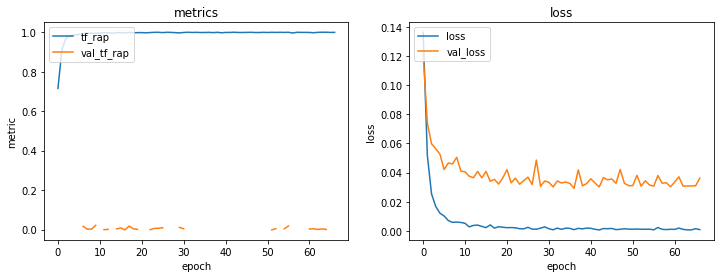

In [199]:
from matplotlib import pyplot as plt
log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(log['tf_rap'], label='tf_rap')
plt.plot(log['val_tf_rap'], label='val_tf_rap')

plt.title('metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(log['loss'], label='loss') 
plt.plot(log['val_loss'], label='val_loss') 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left') 

# Save image
plt.savefig(F'{path}/logs/{model_name}.jpg')

In [216]:
# Add Features
train_df_balanced['features'] = list(train_x)
valid_df['features'] = list(valid_x)

In [217]:
# Pred
train_df_balanced['probability'] = model.predict(train_x)
valid_df['probability'] = model.predict(valid_x)

In [222]:
full = pd.concat([train_df_balanced, valid_df], axis=0, ignore_index=True)
full = full[['alert_key', 'set_name', 'probability']]
full.to_csv(F'{path}/{model_name}.csv', index=False)

In [39]:
# # Apply Exclusion Rules: 'occupation_code_2.0'
# public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'occupation_code_2.0', value = 1), axis=1)
# public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # Apply Exclusion Rules: 'occupation_code_6.0'
# public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'occupation_code_6.0', value = 1), axis=1)
# public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # Apply Exclusion Rules: 'occupation_code_7.0'
# # public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'occupation_code_7.0', value = 1), axis=1)
# # public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # # Apply Exclusion Rules: 'occupation_code_20.0'
# # public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'occupation_code_20.0', value = 1), axis=1)
# # public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # # Apply Exclusion Rules: 'occupation_code_21.0'
# public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'occupation_code_21.0', value = 1), axis=1)
# public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # # Apply Exclusion Rules: 'trans_no_1.0'
# # public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'trans_no_1.0', value = 1), axis=1)
# # public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # # Apply Exclusion Rules: 'trans_no_3.0'
# # public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'trans_no_3.0', value = 1), axis=1)
# # public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)
# # # Apply Exclusion Rules: 'tx_type_debit_3.0'
# public_df['exclusion'] = public_df.apply(lambda row: apply_exclusion_rules(row['features'], features = dummies + numerical, feature = 'tx_type_debit_3.0', value = 1), axis=1)
# public_df['probability'] = public_df.apply(lambda row: 0 if row['exclusion'] else row['probability'], axis=1)

Old Split ( train, valid, test )

| experiment                                                                         | inputs | train recall-n | valid recall-n | public   | remark                                        |
| ---------------------------------------------------------------------------------- | ------ | -------------- | -------------- | -------- | --------------------------------------------- |
| lstm_31t_65f_epochs150_batchsize16_lr0.001_dropout20_units100                      | 31,65  | 0.84326        | 0.39407        |          | regression: add dense between lstm and output |
| lstm_31t_65f_epochs150_batchsize16_lr0.001_dropout20_units200                      | 31,65  | 0.91667        | 0.32084        | 0.010570 | regression: units to 200                      |
| lstm_bi_31t_65f_epochs150_batchsize16_lr0.001_dropout20_units200                   | 31,65  | 0.91959        | 0.32544        | 0.007309 | regression: bi-directional                    |
| lstm_bi_31t_72f_epochs150_batchsize16_lr0.001_dropout20_units200                   | 31,72  | 0.91521        | 0.32054        | 0.009532 | regression: add week 1~7 as one-hot           |
| lstm_bi_31t_72f_binary_epochs150_batchsize16_lr0.001_dropout20_units200            | 31,72  | 0.84717        | 0.32434        |          | classification                                |
| lstm_bi_31t_72f_epochs150_batchsize16_lr0.001_dropout20                            | 31,72  | 0.93795        | 0.33490        |          | regression: remove dense                      |
| lstm_31t_73f_epochs150_batchsize16_lr0.001_dropout20                               | 31,73  | 0.92200        | 0.31775        | 0.006949 | regression: add day of year                   |
| lstm_31t_73f_epochs150_batchsize16_lr0.001_dropout20 (exclusion rules)             | 31,73  |                |                | 0.007250 | regression: add day of year                   |
| lstm_31t_73f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20                   | 31,73  | 0.91057        | 0.33506        | 0.00826  | regression: use asset ratio                   |
| lstm_31t_73f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20 (exclusion rules) | 31,73  |                |                | 0.00826  | regression: use asset ratio                   |

New Split

| experiment                                                                              | inputs | train recall-n | valid recall-n | public    | remark                                |
| --------------------------------------------------------------------------------------- | ------ | -------------- | -------------- | --------- | ------------------------------------- |
| lstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20                        | 31,74  | 0.99990        | 0.02884        | new split | regression: add cdtx_id_tw remove doy |
| lstm_31t_74f_asset_ratio_epochs150_batchsize64_lr0.001_dropout20                        | 31,74  | 0.99990        | 0.02796        | new split | regression                            |
| lstm_31t_74f_asset_ratio_epochs150_batchsize128_lr0.001_dropout20                       | 31,74  | 0.99990        | 0.02803        | new split | regression                            |
| lstm_61t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20                        | 61,83  | 0.99992        | 0.02796        | new split | regression: 74 + doy, ccba            |
| clstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3      | 31,74  | 0.99999        | 0.02880        | new split | regression                            |
| clstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters16_kernel3     | 31,74  | 0.99999        | 0.02845        | new split | regression                            |
| clstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters32_kernel3     | 31,74  | 0.99986        | 0.02807        | new split | regression                            |
| clstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters32_kernel8     | 31,74  | 0.99999        | 0.02845        | new split | regression                            |
| clstm_bi_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3   | 31,74  | 0.99957        | 0.02800        | new split | regression                            |
| clstm_80t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3      | 80,74  | 0.99992        | 0.02838        | new split | regression                            |
| clstm_91t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3      | 91,74  | 0.99983        | 0.02813        | new split | regression                            |
| clstm_61t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3      | 61,83  | 0.99992        | 0.02880        | new split | regression: 74 + doy, ccba            |
| clstm_61t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters3x32_kernel3x3 | 61,83  | 0.99992        | 0.02796        | new split | regression: 74 + doy, ccba            |
| clstm_8t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3       | 8,83   | 0.99979        | 0.02810        | new split | regression: 74 + doy, ccba            |


train recall_n: 0.99992
valid recall_n: 0.0288


In [201]:
train_recall_n = tf_rap(train_df_balanced['sar_flag'].tolist(), train_df_balanced['probability'].tolist()).numpy()
print('train recall_n: ', round(train_recall_n, 5))
valid_recall_n = tf_rap(valid_df['sar_flag'].tolist(), valid_df['probability'].tolist()).numpy()
print('valid recall_n: ', round(valid_recall_n, 5))
# valid2_recall_n = tf_rap(valid_df2['sar_flag'].tolist(), valid_df2['probability_henry'].tolist()).numpy()
# print('henry recall_n: ', round(valid2_recall_n, 5))
# valid2_recall_n = tf_rap(valid_df2['sar_flag'].tolist(), valid_df2['probability'].tolist()).numpy()
# print('valid 2 recall_n: ', round(valid2_recall_n, 5))

train recall_n:  0.99979
valid recall_n:  0.0281


In [202]:
raise SystemExit(F'{model_name} is exist')

SystemExit: clstm_8t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3 is exist

c:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


#### Variables in last 15 days ( x-max = 15 = target_day )


In [ ]:
full_df = pd.concat([train_df, valid_df], ignore_index=True)
full_x = np.concatenate([train_x, valid_x], axis=0)

In [ ]:
positive = full_df[full_df['sar_flag'].eq(1)].drop_duplicates(subset=['alert_key']).index.tolist()
negative = full_df[full_df['sar_flag'].eq(0)].drop_duplicates(subset=['alert_key']).index.tolist()

In [ ]:
full_x_positive = full_x[positive]
full_x_negative = full_x[negative]
print("full_x_positive.shape", full_x_positive.shape)
print("full_x_negative.shape", full_x_negative.shape)

full_x_positive.shape (215, 31, 73)
full_x_negative.shape (20653, 31, 73)


In [ ]:
rich = full_df[full_df['total_asset'] >= full_df.describe()['total_asset']['75%']].index.tolist()
poor = full_df[full_df['total_asset'] < full_df.describe()['total_asset']['75%']].index.tolist()

In [ ]:
full_x_rich = full_x[rich,:,:]
full_x_poor = full_x[poor,:,:]
print("full_x_rich.shape", full_x_rich.shape)
print("full_x_poor.shape", full_x_poor.shape)

full_x_rich.shape (10592, 31, 73)
full_x_poor.shape (31776, 31, 73)


Variables in last 30 + 1 days (difference between each day and the day before)


In [ ]:
def difference_between_each_day_and_the_day_before(data):
    return data[:, 1:, :] - data[:, :-1, :]

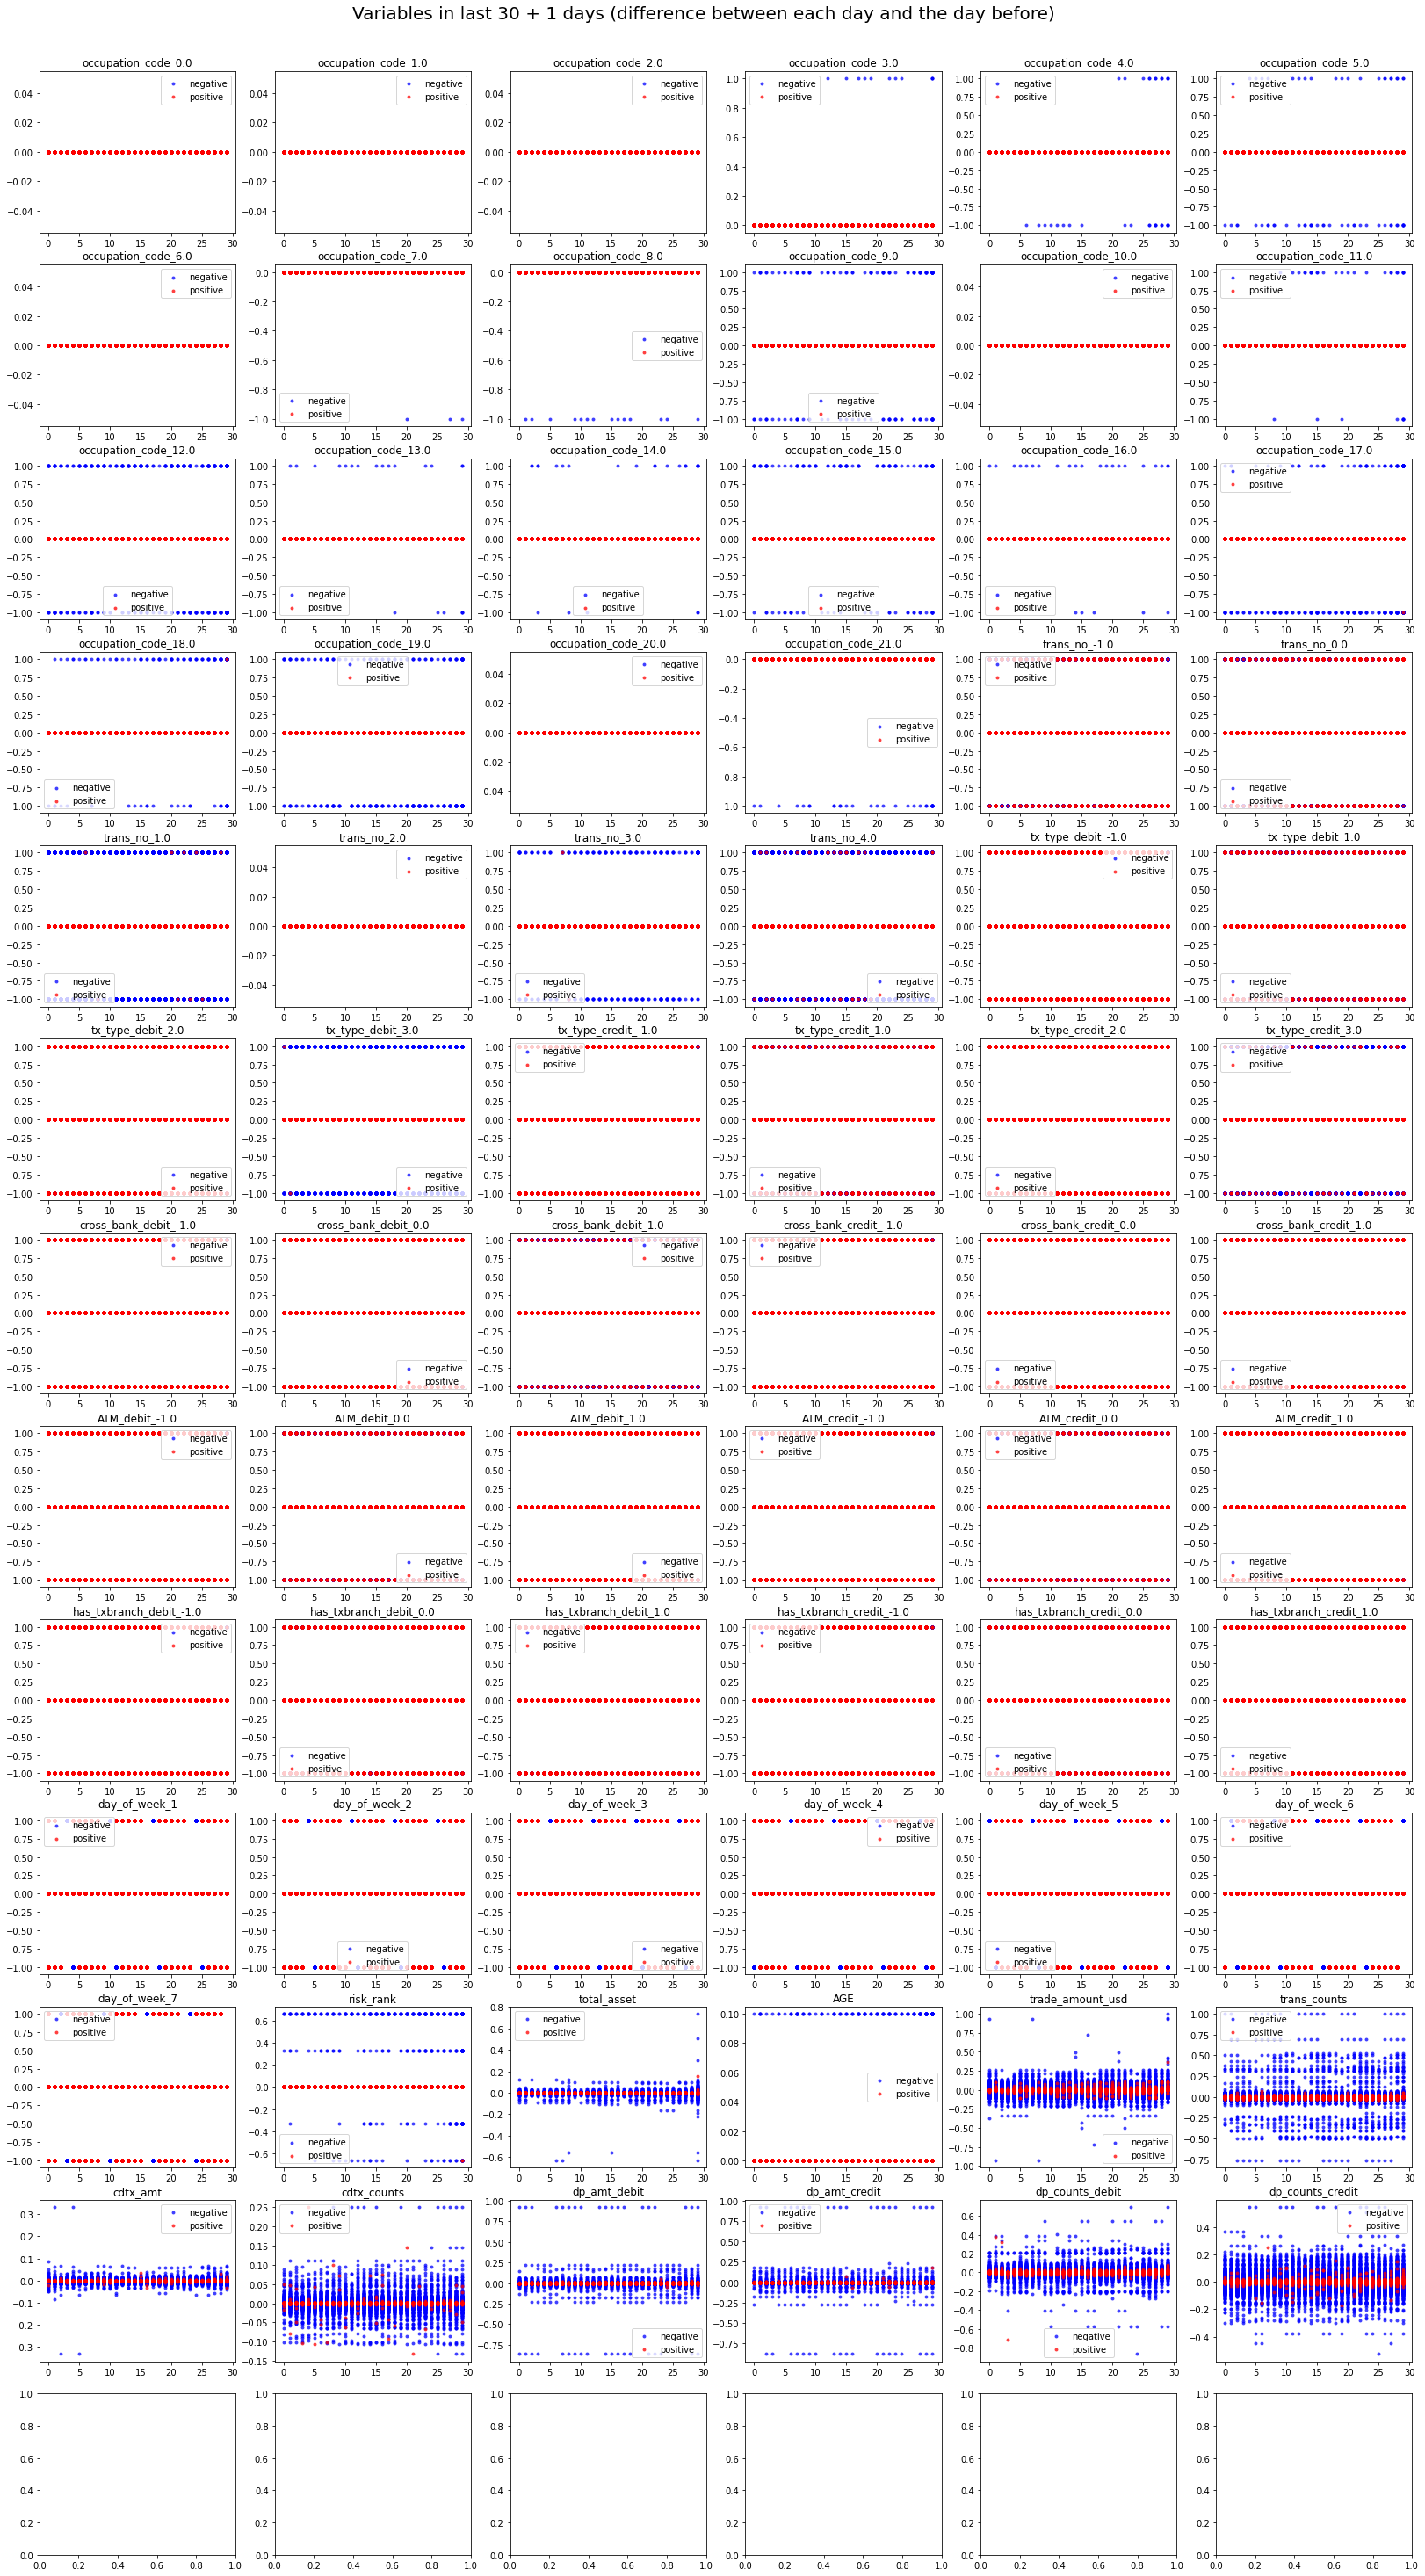

In [ ]:
parameters = (dummies + numerical)
cols = 6
rows = (len(parameters)//cols)+1
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, rows*4))
f.suptitle('Variables in last 30 + 1 days (difference between each day and the day before)', fontsize=20, y=0.90)
for i, val in enumerate(parameters):
    pxs = np.array([list(range(len(data))) for data in difference_between_each_day_and_the_day_before(full_x_positive)[:,:,i]]).ravel()
    pys = np.array(difference_between_each_day_and_the_day_before(full_x_positive)[:,:,i]).ravel()
    nxs = np.array([list(range(len(data))) for data in difference_between_each_day_and_the_day_before(full_x_negative)[:,:,i]]).ravel()
    nys = np.array(difference_between_each_day_and_the_day_before(full_x_negative)[:,:,i]).ravel()
    axes[i//cols,i%cols].scatter(nxs, nys, s=15, linewidth=0.01, alpha=0.75, label='negative', color='blue')
    axes[i//cols,i%cols].scatter(pxs, pys, s=15, linewidth=0.01, alpha=0.75, label='positive', color='red')
    # axes[i//cols,i%cols].plot(xxx[j])
    axes[i//cols,i%cols].legend(loc="best")
    axes[i//cols,i%cols].set_title(val)

Variables in last 30 + 1 days (difference between each day and the target day)


In [ ]:
def difference_between_each_day_and_the_target_day(data):
    return data[:, -1:, :] - data[:, :-1, :]

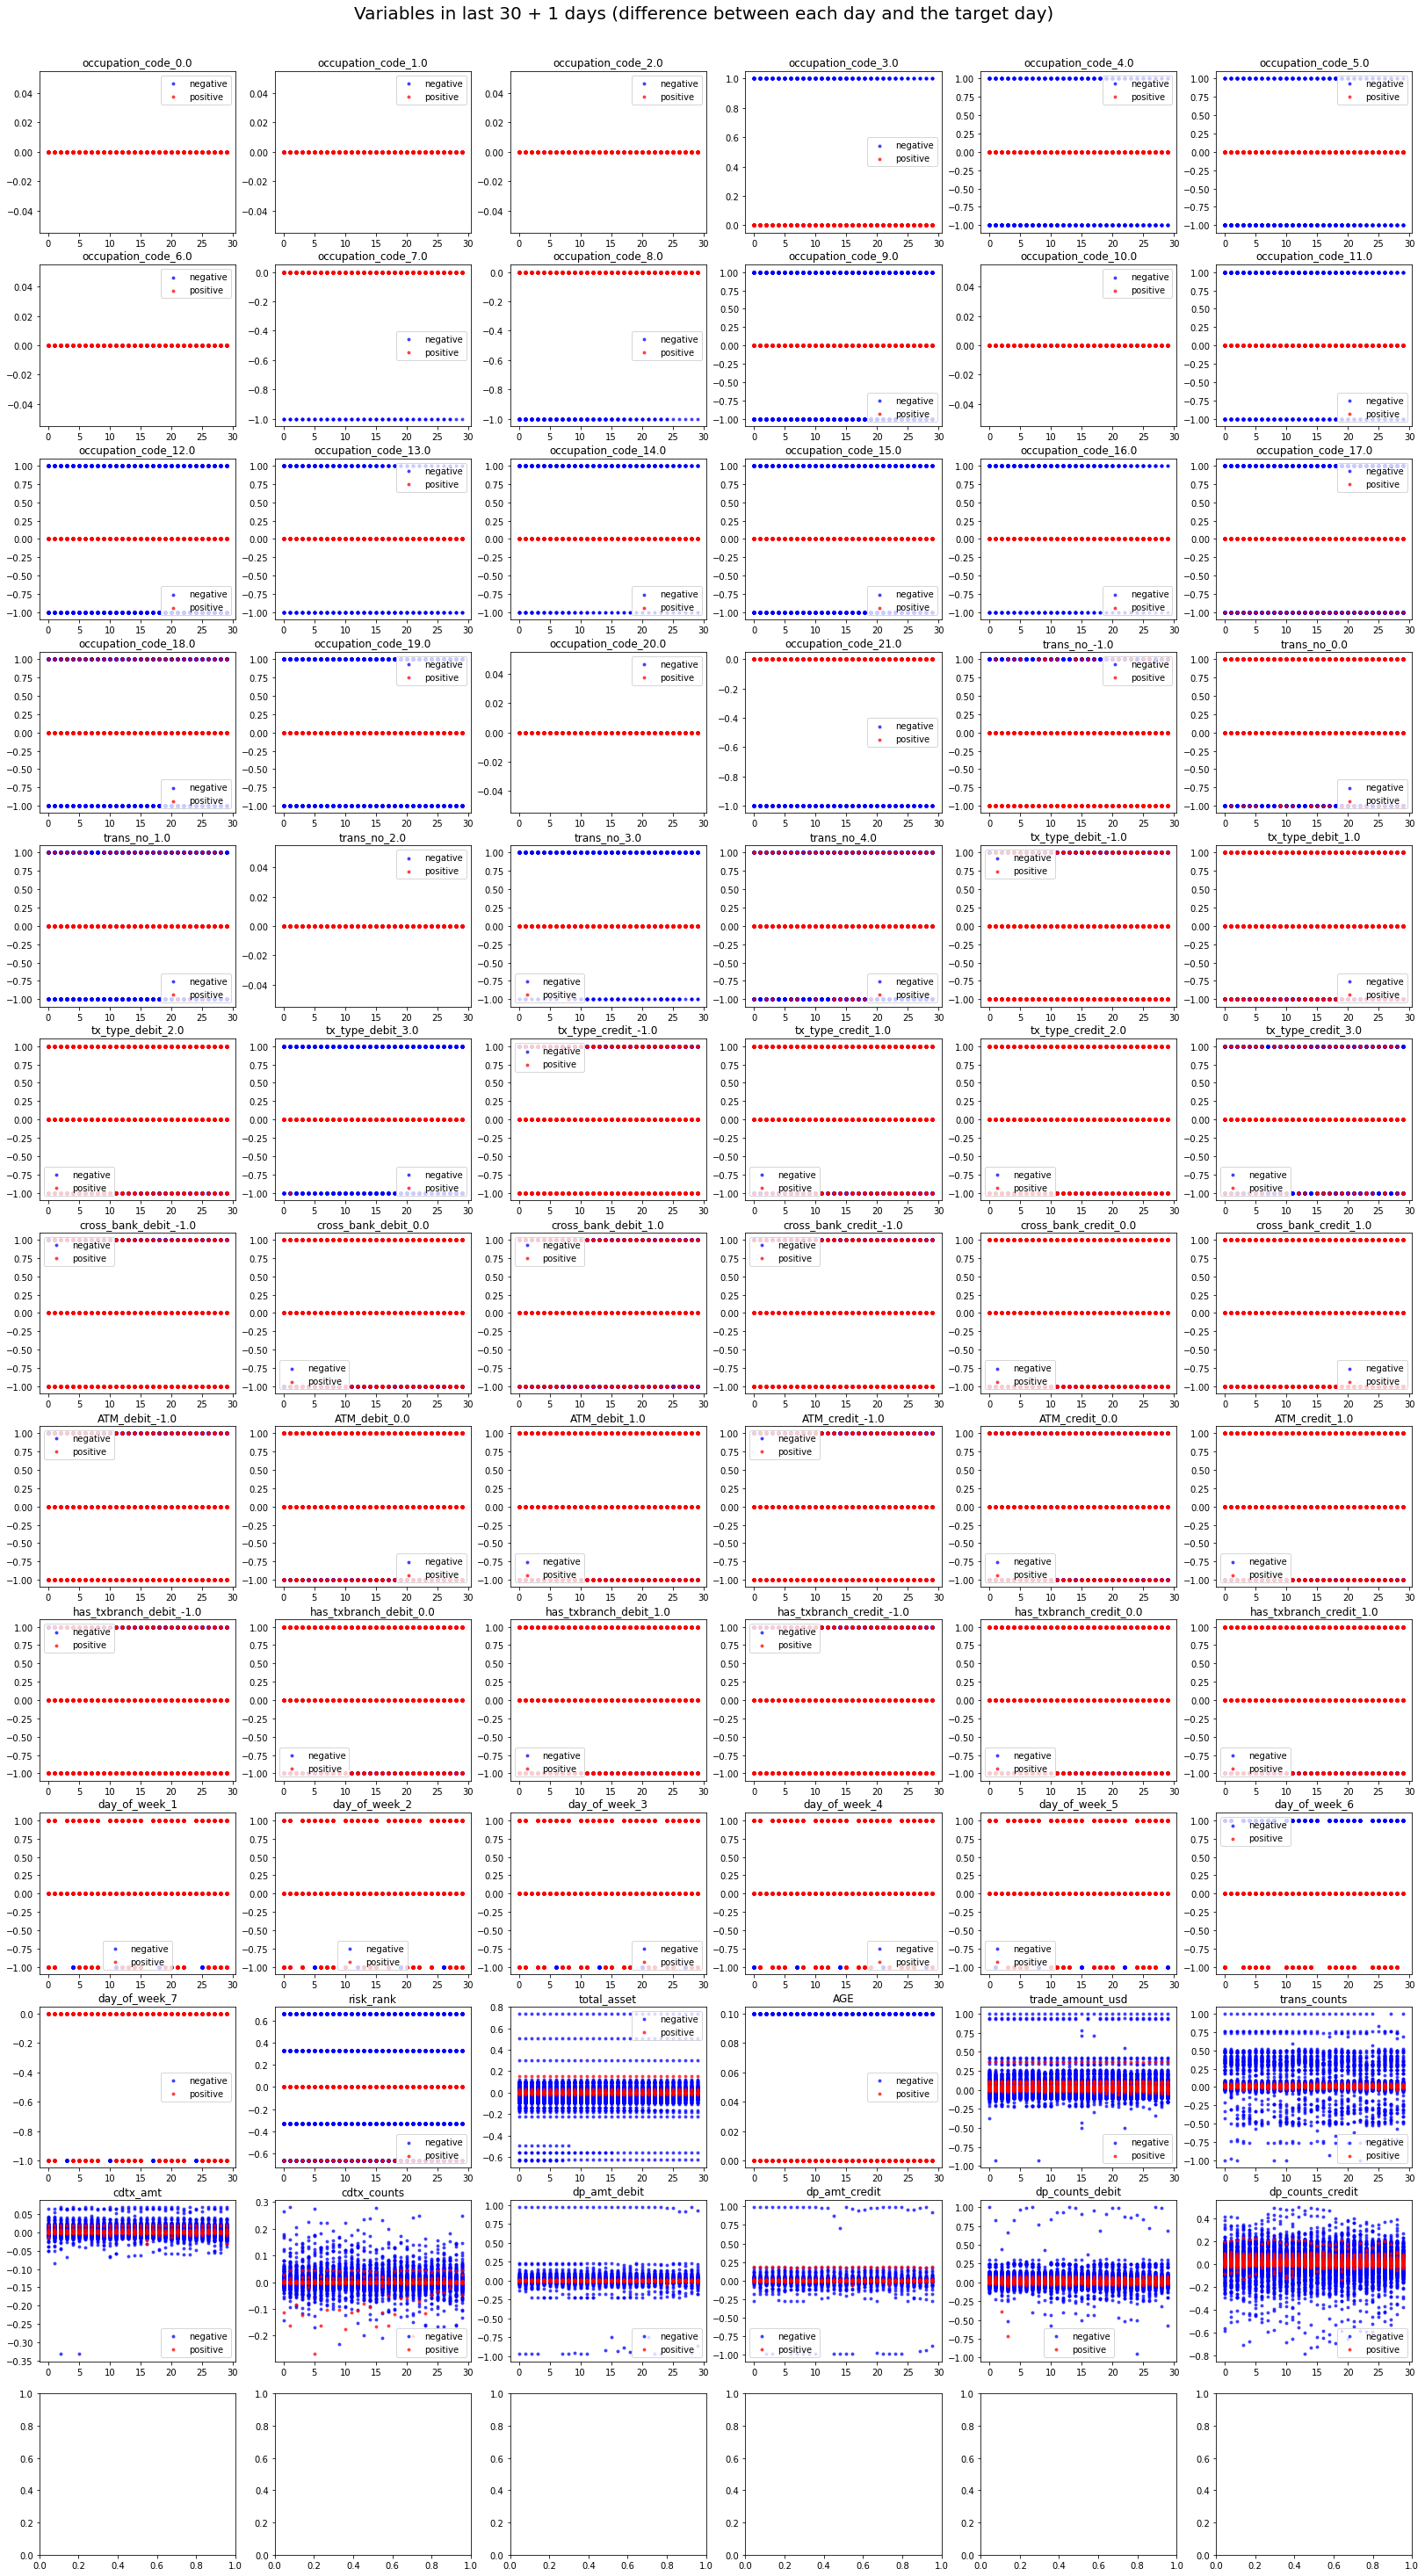

In [ ]:
parameters = (dummies + numerical)
cols = 6
rows = (len(parameters)//cols)+1
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, rows*4))
f.suptitle('Variables in last 30 + 1 days (difference between each day and the target day)', fontsize=20, y=0.90)
for i, val in enumerate(parameters):
    pxs = np.array([list(range(len(data))) for data in difference_between_each_day_and_the_target_day(full_x_positive)[:,:,i]]).ravel()
    pys = np.array(difference_between_each_day_and_the_target_day(full_x_positive)[:,:,i]).ravel()
    nxs = np.array([list(range(len(data))) for data in difference_between_each_day_and_the_target_day(full_x_negative)[:,:,i]]).ravel()
    nys = np.array(difference_between_each_day_and_the_target_day(full_x_negative)[:,:,i]).ravel()
    axes[i//cols,i%cols].scatter(nxs, nys, s=15, linewidth=0.01, alpha=0.75, label='negative', color='blue')
    axes[i//cols,i%cols].scatter(pxs, pys, s=15, linewidth=0.01, alpha=0.75, label='positive', color='red')
    # axes[i//cols,i%cols].plot(xxx[j])
    axes[i//cols,i%cols].legend(loc="best")
    axes[i//cols,i%cols].set_title(val)

Variables in last 30 + 1 days


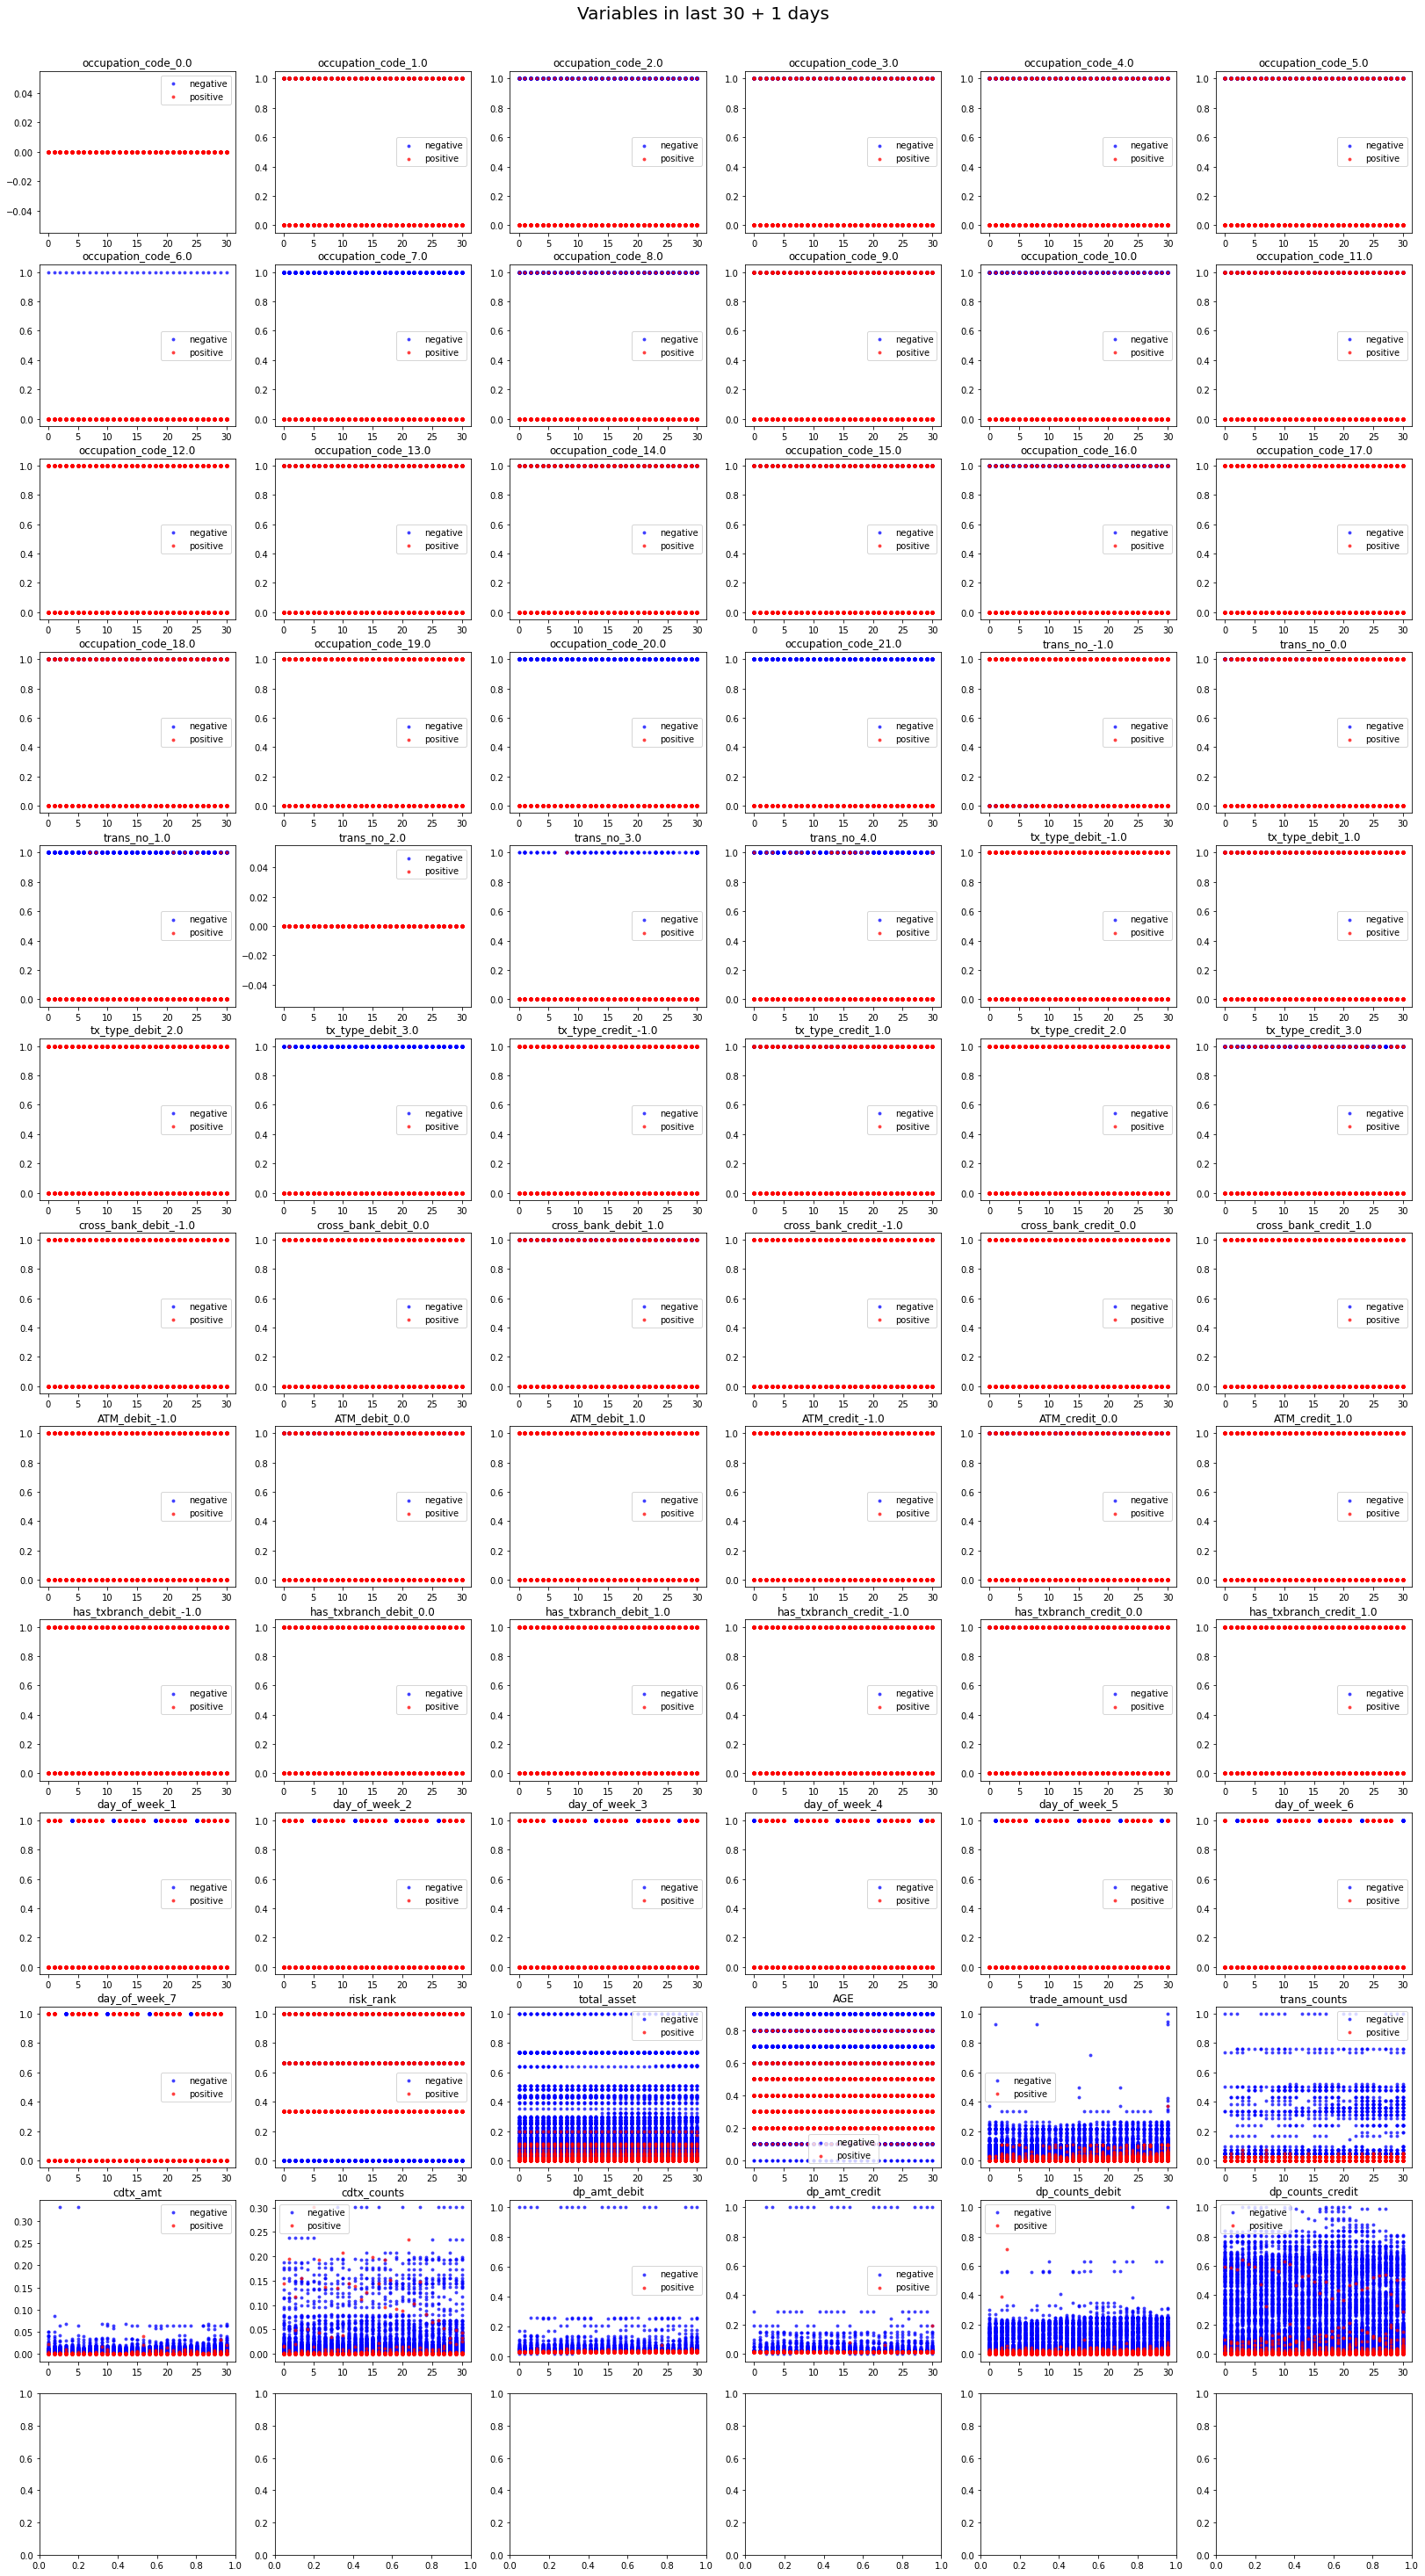

In [ ]:
parameters = dummies + numerical
cols = 6
rows = (len(parameters)//cols)+1
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, rows*4))
f.suptitle('Variables in last 30 + 1 days', fontsize=20, y=0.90)
for i, val in enumerate(parameters):
    pxs = np.array([list(range(len(data))) for data in full_x_positive[:,:,i]]).ravel()
    pys = np.array(full_x_positive[:,:,i]).ravel()
    nxs = np.array([list(range(len(data))) for data in full_x_negative[:,:,i]]).ravel()
    nys = np.array(full_x_negative[:,:,i]).ravel()
    axes[i//cols,i%cols].scatter(nxs, nys, s=15, linewidth=0.01, alpha=0.75, label='negative', color='blue')
    axes[i//cols,i%cols].scatter(pxs, pys, s=15, linewidth=0.01, alpha=0.75, label='positive', color='red')
    # axes[i//cols,i%cols].plot(xxx[j])
    axes[i//cols,i%cols].legend(loc="best")
    axes[i//cols,i%cols].set_title(val)

Variables in last 30 + 1 days ( rich vs poor )


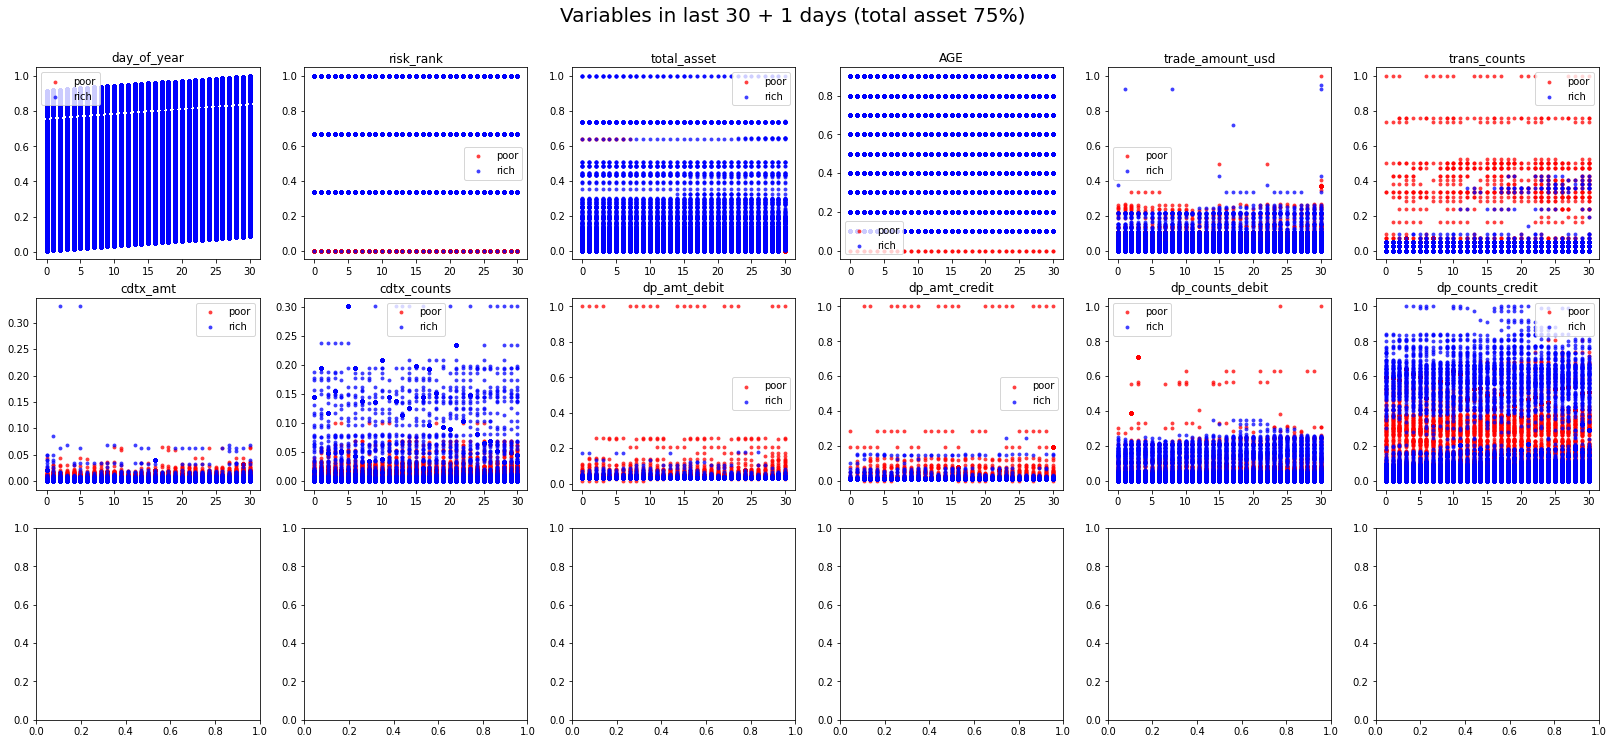

In [ ]:
parameters = numerical
cols = 6
rows = (len(parameters)//cols)+1
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, rows*4))
f.suptitle('Variables in last 30 + 1 days (total asset 75%)', fontsize=20, y=0.95)
for i, val in enumerate(parameters):
    pxs = np.array([list(range(len(data))) for data in full_x_rich[:,:,len(dummies)+i]]).ravel()
    pys = np.array(full_x_rich[:,:,len(dummies)+i]).ravel()
    nxs = np.array([list(range(len(data))) for data in full_x_poor[:,:,len(dummies)+i]]).ravel()
    nys = np.array(full_x_poor[:,:,len(dummies)+i]).ravel()
    axes[i//cols,i%cols].scatter(nxs, nys, s=15, linewidth=0.01, alpha=0.75, label='poor', color='red')
    axes[i//cols,i%cols].scatter(pxs, pys, s=15, linewidth=0.01, alpha=0.75, label='rich', color='blue')
    axes[i//cols,i%cols].legend(loc="best")
    axes[i//cols,i%cols].set_title(val)

## Submission


In [55]:
model_name = "lstm_31t_74f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20"
model_name = "clstm_61t_83f_asset_ratio_epochs150_batchsize16_lr0.001_dropout20_filters8_kernel3"
with strategy.scope():    
    # model = get_model_lstm(train_x.shape, LR_START, DROPOUT, UNITS)
    model = get_model_clstm1d(train_x.shape, LR_START, DROPOUT, UNITS, FILTERS, KERNEL_SIZE)
    model.load_weights(F'{path}/models/{model_name}.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [69]:
private_df['probability'] = model.predict(private_x)

In [71]:
submission = pd.read_csv(os.path.join(path, 'submission/example.csv'))[['alert_key']]
submission = pd.merge(submission, private_df[['alert_key', 'probability']], on='alert_key', how='left')

In [75]:
submission['probability'] = submission['probability'].fillna(0)
submission['probability'] = submission['probability'].astype('float')
submission['probability'] = submission['probability'].apply(lambda x: 0 if x < 0 else x)
submission['probability'] = submission['probability'].apply(lambda x: 1 if x > 1 else x)
submission.describe()

,alert_key,probability
count,3850.000000,3850.000000
mean,365303.605195,0.018054
std,7309.639174,0.095544
min,352249.000000,0.000000
25%,358829.250000,0.000000
50%,365574.000000,0.000000
75%,371367.500000,0.008150
max,378428.000000,1.000000


In [77]:
submission.to_csv(os.path.join(path, f'submission/private/{model_name}.csv'), index=False)